# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [2]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [3]:
bandit0 = BanditProblem(0)

In [4]:
bandit0.get_num_arms()

3

In [5]:
bandit0.get_reward(arm=0)

1.8255111545554434

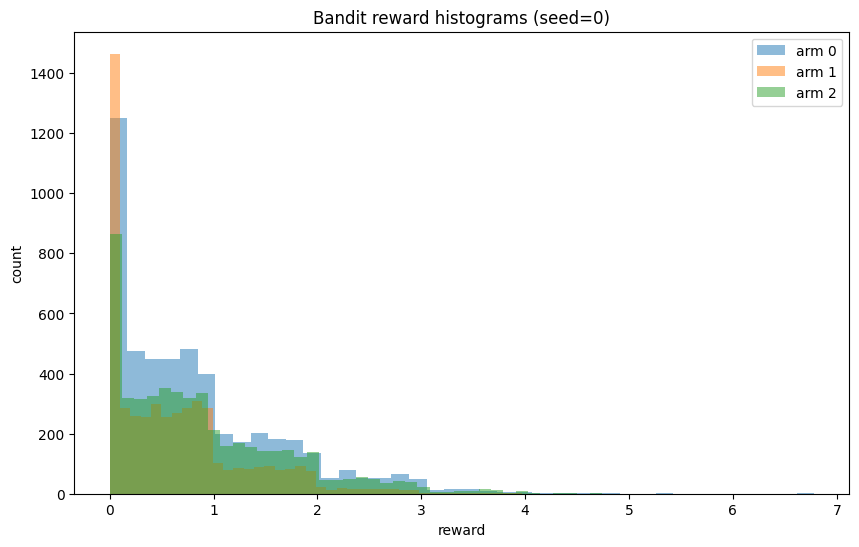

Arm  |  mean    std     p95     max
0    | 0.8283  0.8248  2.5340  6.7825
1    | 0.6294  0.6656  1.9044  3.9734
2    | 0.8917  0.7984  2.5137  4.7381

Empirically best arm by mean (seed=0): 2


In [ ]:
# YOUR CHANGES HERE
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)
bandit = bandit0  
A = bandit.get_num_arms()

def sample_rewards(bandit, arm, n=5000):
    return np.array([bandit.get_reward(arm) for _ in range(n)])

all_stats = []
plt.figure(figsize=(10, 6))

for a in range(A):
    r = sample_rewards(bandit, a, n=5000)
    mean = r.mean()
    std = r.std(ddof=1)
    p95 = np.percentile(r, 95)
    mx = r.max()
    all_stats.append((a, mean, std, p95, mx))
    
    plt.hist(r, bins=40, alpha=0.5, label=f"arm {a}")

plt.title("Bandit reward histograms (seed=0)")
plt.xlabel("reward")
plt.ylabel("count")
plt.legend()
plt.show()

print("Arm  |  mean    std     p95     max")
for a, mean, std, p95, mx in all_stats:
    print(f"{a:<4} | {mean:0.4f}  {std:0.4f}  {p95:0.4f}  {mx:0.4f}")

best_arm = max(all_stats, key=lambda t: t[1])[0]
print(f"\nEmpirically best arm by mean (seed=0): {best_arm}")


Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

In [25]:
# YOUR CHANGES HERE

import pandas as pd


# --- Required seeds ---
BANDIT_SEED = 2025002      # fresh bandit for "live" run
ALGO_SEED = 2025002        # seed the TS sampler for reproducibility

# Fresh bandit object per instructions
bandit = BanditProblem(BANDIT_SEED)
K = bandit.get_num_arms()

# Thompson Sampling with Gaussian prior on arm means
rng = np.random.default_rng(ALGO_SEED)

T = 1000  # number of actions
m = np.zeros(K)       # prior mean for each arm
v = np.ones(K)        # prior variance for each arm
tau2 = 1.0            # assumed reward noise variance scale (heuristic)

actions = []
rewards = []

# (Optional) warm start: one pull per arm to initialize posteriors (common practice)
for a in range(K):
    r = bandit.get_reward(a)
    actions.append(a)
    rewards.append(r)
    v[a] = 1.0 / (1.0/v[a] + 1.0/tau2)
    m[a] = v[a] * (m[a]/v[a] + r/tau2)

# Continue TS to reach exactly T actions total
for t in range(K, T):
    theta_samples = rng.normal(m, np.sqrt(v))
    a = int(np.argmax(theta_samples))
    r = bandit.get_reward(a)
    actions.append(a)
    rewards.append(r)
    v[a] = 1.0 / (1.0/v[a] + 1.0/tau2)
    m[a] = v[a] * (m[a]/v[a] + r/tau2)

# Save action-reward pairs
history = pd.DataFrame({"action": actions, "reward": rewards})
out_path = "history.tsv"
history.to_csv(out_path, sep="\t", index=False)

# Show a small preview so you can sanity-check locally
history.head(10), out_path


(   action    reward
 0       0  1.575207
 1       1  0.000000
 2       2  0.000000
 3       0  1.804006
 4       0  0.432083
 5       0  0.508036
 6       0  0.000000
 7       0  0.410877
 8       0  0.779933
 9       0  0.657080,
 'history.tsv')

Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [27]:

# --- Settings ---
BANDIT_SEED = 2025002          # required "live" seed
T = 1000                       # number of actions to take
NORM_BOUND = 9.0               # max possible reward <= 9 (n in [1,9] and U in [0,1])

bandit = BanditProblem(BANDIT_SEED)
K = bandit.get_num_arms()

# UCB1 state
counts = np.zeros(K, dtype=int)
means = np.zeros(K, dtype=float)

actions = []
rewards = []

# Warm start: pull each arm once
for a in range(K):
    r = bandit.get_reward(a)
    actions.append(a)
    rewards.append(r)
    counts[a] = 1
    means[a] = r  # keep original-scale mean; normalize only for UCB index

# Main UCB1 loop
for t in range(K+1, T+1):  # t = total pulls so far (1-indexed)
    normalized_means = means / NORM_BOUND
    ucbs = normalized_means + np.sqrt(2.0 * np.log(t) / counts)
    a = int(np.argmax(ucbs))
    r = bandit.get_reward(a)

    actions.append(a)
    rewards.append(r)

    counts[a] += 1
    means[a] += (r - means[a]) / counts[a]

history = pd.DataFrame({"action": actions, "reward": rewards})
out_path = "history.tsv"
history.to_csv(out_path, sep="\t", index=False)

# Quick checks
counts_per_arm = history["action"].value_counts().sort_index().to_dict()
last_100_unique = history["action"].tail(100).nunique()

out_path, counts_per_arm, last_100_unique

('history.tsv', {0: 389, 1: 361, 2: 250}, 3)

Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [28]:
# YOUR CHANGES HERE

summary = history.groupby("action")["reward"].agg(
    min_reward="min",
    mean_reward="mean",
    max_reward="max"
).reset_index()

output_path_actions = "actions.tsv"
summary.to_csv(output_path_actions, sep="\t", index=False)

summary, output_path_actions


(   action  min_reward  mean_reward  max_reward
 0       0         0.0     0.597759    3.761461
 1       1         0.0     0.531647    2.988922
 2       2         0.0     0.176597    0.966617,
 'actions.tsv')

Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [29]:
# YOUR CHANGES HERE

import numpy as np
import pandas as pd

# Use the same setup from the previous step
T = 1000
true_means = np.array([1.0, 2.0, 1.5])
mu_star = true_means.max()

# Strategy: uniform (each arm equally likely)
uniform_mean_per_pull = true_means.mean()
uniform_expected_total = T * uniform_mean_per_pull
uniform_expected_regret = T * mu_star - uniform_expected_total

# Strategy: just-i for each arm
just_expected_totals = T * true_means
just_expected_regrets = T * mu_star - just_expected_totals

# Strategy: actual (use the realized total reward from Part 2 run)
actual_total_reward = float(np.sum(history["reward"]))  # from previous run
actual_regret = T * mu_star - actual_total_reward

# Build results table
rows = []

rows.append({
    "strategy": "uniform",
    "expected_total_reward": uniform_expected_total,
    "expected_regret": uniform_expected_regret
})

for i, mu in enumerate(true_means):
    rows.append({
        "strategy": f"just-{i}",
        "expected_total_reward": just_expected_totals[i],
        "expected_regret": just_expected_regrets[i]
    })

rows.append({
    "strategy": "actual",
    "expected_total_reward": actual_total_reward,
    "expected_regret": actual_regret
})

regret_df = pd.DataFrame(rows)


regret_df


,strategy,expected_total_reward,expected_regret
0,uniform,1500.00000,500.00000
1,just-0,1000.00000,1000.00000
2,just-1,2000.00000,0.00000
3,just-2,1500.00000,500.00000
4,actual,468.60202,1531.39798


In [33]:
history = pd.read_csv("history.tsv", sep="\t")

actions = history.groupby("action")["reward"].agg(
    min_reward="min",
    mean_reward="mean",
    max_reward="max"
).reset_index()

actions.to_csv("actions.tsv", sep="\t", index=False)

# Compute regrets using estimated means
mean_rewards = actions.set_index("action")["mean_reward"]
benchmark_reward = 1000 * mean_rewards.max()

# Actual strategy regret
actual_total = history["reward"].sum()
actual_regret = benchmark_reward - actual_total

# Uniform strategy regret
uniform_total = 1000 * mean_rewards.mean()
uniform_regret = benchmark_reward - uniform_total

# Just-i regrets
just_regrets = {f"just-{i}": benchmark_reward - 1000 * mu
                for i, mu in mean_rewards.items()}

# Collect results
rows = [{"strategy": "uniform", "regret": uniform_regret}]
for i in range(len(mean_rewards)):
    rows.append({"strategy": f"just-{i}", "regret": just_regrets[f"just-{i}"]})
rows.append({"strategy": "actual", "regret": actual_regret})

strategies = pd.DataFrame(rows)

# Save strategies.tsv
strategies.to_csv("strategies.tsv", sep="\t", index=False)

print(actions)
print(strategies)

   action  min_reward  mean_reward  max_reward
0       0         0.0     0.597759    3.761461
1       1         0.0     0.531647    2.988922
2       2         0.0     0.176597    0.966617
  strategy      regret
0  uniform  162.424151
1   just-0    0.000000
2   just-1   66.111437
3   just-2  421.161017
4   actual  129.156483


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [ ]:
# YOUR CHANGES HERE

# strategies_df = regret_df[["strategy", "expected_regret"]].rename(columns={"expected_regret": "regret"})

# out_path_strategies = "strategies.tsv"
# strategies_df.to_csv(out_path_strategies, sep="\t", index=False)

# strategies_df, out_path_strategies



(  strategy      regret
 0  uniform   500.00000
 1   just-0  1000.00000
 2   just-1     0.00000
 3   just-2   500.00000
 4   actual  1531.39798,
 'strategies.tsv')

Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.